# Humid Heat Metrics

Humid heat metrics index temperature and humidity, which is often more useful than comparing either variable alone when considering perceived temperature as they together affect the human body's ability to cool itself down. Humid heat metrics are especially important for the safety of outside workers, the elderly, or otherwise high-risk high-exposure individuals. 

Wet Bulb Globe Temperature (WBGT) is a measure of heat stress. The equation for outdoor ($WBGT_{OD}$) and indoor/shaded ($WBGT_{ID}$) WBGTs are:

$WBGT_{od} = 0.7*T_{nwb} + 0.2*T_g + 0.1*T_a$

$WBGT_{id} = 0.7*T_{nwb} + 0.3*T_g$

where $T_a$ refers to Dry Bulb Ambient Temperatue, $T_{nwb}$ is the Natural Wet Bulb Temperature wet bulb temperature with exposure to wind and sun, and $T_g$ is the Globe Temperature temperature taken from inside a copper globe painted black and exposed to the sun.

However this formula is complicated by the reality that Natural Wet Bulb Temperature and Globe Temperature are not always readily available variables from weather stations or atmospheric models.

In this notebook we will demonstrate the Australian Bureau of Meteorology (ABM) and Bernard methods of predicting wet bulb global temperature with a focus on the July 1995 Chicago heatwave.

For our analysis, we have ERA5 renanalysis data for the lower contiguous United States (50N, 24S, -66E, -125W) from July 1995 with the variables: 2-meter temperature, 2-meter dew point temperature, surface pressure, and *u*/*v* wind components.

In [61]:
import geocat.datafiles as gcd
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [62]:
era5_file = "../../adaptor.mars.internal-1721674223.0932782-17053-4-ca11ba26-b36b-4a33-902e-b4ed0d92364e.nc"
era5 = xr.open_dataset(era5_file)
era5

<xarray.Dataset> Size: 370MB
Dimensions:    (longitude: 237, latitude: 105, time: 744)
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
  * time       (time) datetime64[ns] 6kB 1995-07-01 ... 1995-07-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 74MB ...
    v10        (time, latitude, longitude) float32 74MB ...
    d2m        (time, latitude, longitude) float32 74MB ...
    t2m        (time, latitude, longitude) float32 74MB ...
    sp         (time, latitude, longitude) float32 74MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-22 18:50:30 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [74]:
# Convert from Kelvin to Celcius 

era5['t2m_C'] = era5['t2m'] - 273.15 
era5['d2m_C'] = era5['d2m'] - 273.15

In [105]:
# Chicago coordinates
lat_chicago = 41.8781
lon_chicago = -87.6298

## Australian Bureau of  (ABM)

Method of estimating Wet Bulb Global Temperature

- tends to overpredict WBGT compared to other models
- assumes full sunlight and light breeze

In [63]:
def calc_abm_wbgt(t_a, rh):
    e = (rh / 100)**17.27 * (t_a/(337.7 * t_a)) # water vapor pressure [hPa]
    wbgt = (0.567 * t_a) + (0.393 * e) + 3.94
    return wbgt

To use our ERA5 data in this equation, we need to first approximate relative humidity using the Clausius-Clapeyron Equation:

In [75]:
def _calc_saturation_vapor_pressure(T_a): # Magnus-Tetens Approximation\
    e_sat = 6.11 * np.exp((17.625 * T_a) / (T_a + 243.04)) # Saturation Vapor Pressure in hPa
    return e_sat

def calc_relative_humidity_era5(T_a, T_d):
    e_sat = _calc_saturation_vapor_pressure(T_a) # saturation vapor pressure
    e = 6.11*np.exp(17.625 * T_d / (243.04 + T_d)) # vapor pressure from dew point temp
    rh = 100 * e / e_sat  # Clausius-Clapeyron equation
    return rh

rh = calc_relative_humidity_era5(era5.t2m_C, era5.d2m_C)

In [76]:
wbgt_abm = calc_abm_wbgt(era5.t2m_C, rh)
wbgt_abm

<xarray.DataArray (time: 744, latitude: 105, longitude: 237)> Size: 74MB
array([[[22.075209 , 23.015654 , 21.95886  , ..., 10.766169 ,
          9.983853 , 10.17072  ],
        [21.410894 , 22.069967 , 20.655495 , ...,  9.748951 ,
         10.108799 , 10.534065 ],
        [21.501513 , 20.821938 , 19.399834 , ..., 10.953621 ,
         11.479606 , 11.925975 ],
        ...,
        [15.3181305, 15.3410225, 15.3181305, ..., 18.044672 ,
         18.086636 , 18.210604 ],
        [15.481712 , 15.480764 , 15.458342 , ..., 18.00796  ,
         18.055626 , 18.120972 ],
        [15.657667 , 15.643379 , 15.621439 , ..., 18.089003 ,
         18.048964 , 18.051386 ]],

       [[22.09286  , 23.049517 , 22.010841 , ..., 10.37941  ,
          9.893753 , 10.192608 ],
        [21.467182 , 22.143887 , 20.845781 , ...,  9.695606 ,
          9.944869 , 10.446331 ],
        [21.155756 , 20.928768 , 19.623032 , ..., 10.792925 ,
         11.173454 , 11.716141 ],
...
        [15.727291 , 15.758301 , 15.770222 , ..., 19.223433 ,
         19.285423 , 19.32833  ],
        [15.796923 , 15.8088455, 15.861309 , ..., 19.127134 ,
         19.182444 , 19.208668 ],
        [15.899931 , 15.920923 , 15.940945 , ..., 19.176718 ,
         19.112358 , 19.048456 ]],

       [[15.579454 , 16.433084 , 15.686752 , ..., 14.314728 ,
         13.266039 , 13.21072  ],
        [15.297131 , 16.060162 , 15.763042 , ..., 13.56267  ,
         13.700958 , 13.764393 ],
        [16.035831 , 15.803101 , 15.505049 , ..., 13.987106 ,
         14.20409  , 14.2613125],
        ...,
        [15.792164 , 15.811716 , 15.845095 , ..., 19.261585 ,
         19.27589  , 19.312601 ],
        [15.860825 , 15.871798 , 15.918066 , ..., 19.162893 ,
         19.16623  , 19.154305 ],
        [15.941425 , 15.970516 , 15.998188 , ..., 19.156216 ,
         19.059917 , 18.930696 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
  * time       (time) datetime64[ns] 6kB 1995-07-01 ... 1995-07-31T23:00:00

Text(-84.6298, 38.8781, 'Chicago')

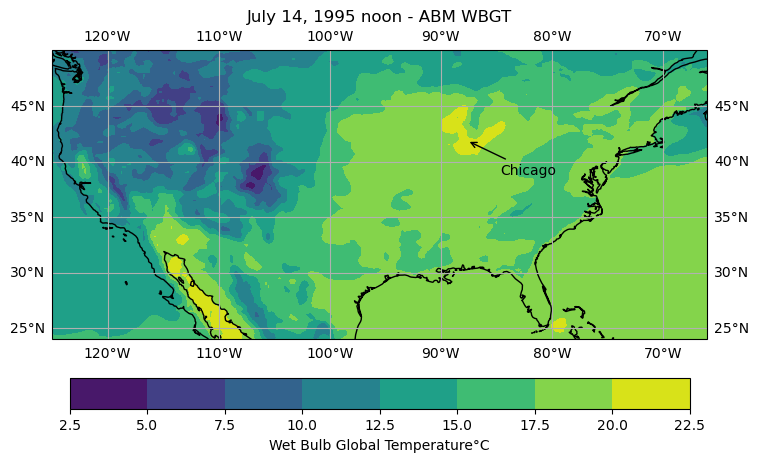

In [106]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contourf(era5.longitude, era5.latitude, wbgt_abm.sel(time='1995-07-14T12'))

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Wet Bulb Global Temperature' + u'\N{DEGREE SIGN}'+ 'C')

ax.set_title('July 14, 1995 noon - ABM WBGT')

ax.annotate('Chicago', xy=(lon_chicago, lat_chicago), xytext=(lon_chicago + 3, lat_chicago - 3),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            transform=ccrs.PlateCarree())

## Bernard

Bernard is a nother method of calculating WBGT that incorporates wind speed.

Thermodynamic Wet Bulb Temperature ($T_{pwb}$) wet bulb temperature in the shade and fanned or rotated. This is the wet bulb typically used for dew point calculations.


In [67]:
def calc_bernard_wbgt(t_a, t_d, v):
    
    if np.all(v < 0.3):
        return np.nan  # Return NaN where velocity is below the threshold
    elif np.all((0.3 <= v) & (v <= 3)):
        wbgt = (0.67 * t_d) + (0.33 * t_a) - (0.48 * np.log10(v) * (t_a - t_d))
    else:
        wbgt = (0.7 * t_d) + (0.3 * t_a)
    
    return wbgt


First we will need to combine our u and v windspeeds:

In [68]:
v = np.sqrt(era5.u10**2 + era5.v10**2)

In [80]:
wbgt_bernard = calc_bernard_wbgt(era5.t2m_C, era5.d2m_C, v)
wbgt_bernard

<xarray.DataArray (time: 744, latitude: 105, longitude: 237)> Size: 74MB
array([[[13.455454 , 12.42034  , 12.256543 , ...,  8.610998 ,
          9.7770605,  9.947123 ],
        [14.145825 , 13.512878 , 14.784948 , ...,  9.719564 ,
          9.990954 , 10.370521 ],
        [13.73335  , 15.488525 , 16.77055  , ..., 10.342603 ,
         10.750455 , 11.15328  ],
        ...,
        [17.672016 , 17.710276 , 17.700598 , ..., 23.569088 ,
         23.577307 , 23.738394 ],
        [17.830944 , 17.90709  , 17.9378   , ..., 23.520458 ,
         23.518326 , 23.663595 ],
        [18.008596 , 18.12814  , 18.125055 , ..., 23.568819 ,
         23.572577 , 23.702164 ]],

       [[12.981875 , 12.150592 , 11.88566  , ...,  8.597938 ,
          9.690448 ,  9.810328 ],
        [13.512053 , 13.062986 , 14.09375  , ...,  9.70711  ,
          9.932138 , 10.322269 ],
        [14.105701 , 15.432535 , 16.470798 , ..., 10.280063 ,
         10.6085205, 11.030698 ],
...
        [17.983402 , 18.03386  , 18.064499 , ..., 24.69218  ,
         24.670235 , 24.605354 ],
        [18.132137 , 18.22725  , 18.297583 , ..., 24.892391 ,
         24.883337 , 24.84552  ],
        [18.347818 , 18.489084 , 18.615845 , ..., 24.895517 ,
         25.017159 , 24.900015 ]],

       [[15.975937 , 15.98847  , 15.04985  , ..., 14.156644 ,
         13.204014 , 13.173527 ],
        [15.586939 , 15.637882 , 15.54393  , ..., 13.466192 ,
         13.569759 , 13.743823 ],
        [15.671857 , 15.594947 , 15.498664 , ..., 14.087311 ,
         14.301859 , 14.49513  ],
        ...,
        [18.1199   , 18.164297 , 18.234274 , ..., 24.743387 ,
         24.688301 , 24.599466 ],
        [18.26571  , 18.35908  , 18.44925  , ..., 24.886984 ,
         24.857136 , 24.800348 ],
        [18.487158 , 18.626022 , 18.758047 , ..., 24.888918 ,
         24.96508  , 24.871767 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
  * time       (time) datetime64[ns] 6kB 1995-07-01 ... 1995-07-31T23:00:00

Text(-84.6298, 38.8781, 'Chicago')

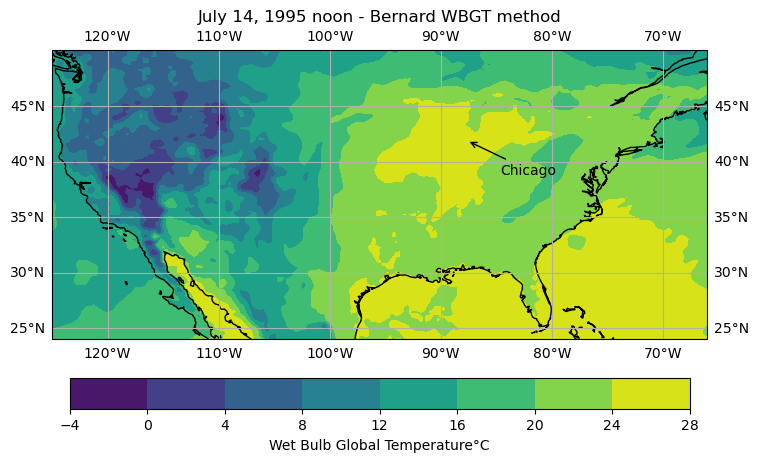

In [107]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contourf(era5.longitude, era5.latitude, wbgt_bernard.sel(time='1995-07-14T12'))

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Wet Bulb Global Temperature' + u'\N{DEGREE SIGN}'+ 'C')

ax.set_title('July 14, 1995 noon - Bernard WBGT method')

ax.annotate('Chicago', xy=(lon_chicago, lat_chicago), xytext=(lon_chicago + 3, lat_chicago - 3),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            transform=ccrs.PlateCarree())

## Comparing methods

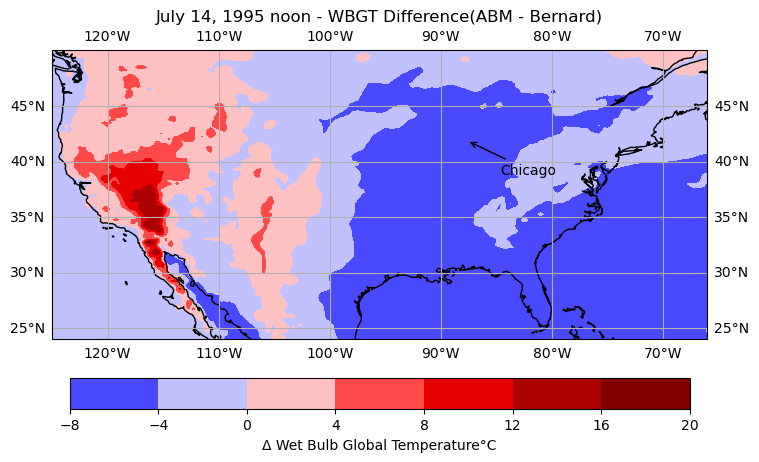

In [112]:
from matplotlib.colors import TwoSlopeNorm

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

diff = wbgt_abm.sel(time='1995-07-14T12') - wbgt_bernard.sel(time='1995-07-14T12')

abs_max = max(abs(diff.min()), abs(diff.max()))
norm = TwoSlopeNorm(vmin=-1*abs_max, vcenter=0, vmax=abs_max)
c = plt.contourf(era5.longitude, era5.latitude, diff, cmap='seismic', norm=norm)

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('\N{GREEK CAPITAL LETTER DELTA} Wet Bulb Global Temperature' + u'\N{DEGREE SIGN}'+ 'C')
ax.set_title('July 14, 1995 noon - WBGT Difference(ABM - Bernard)')


# Add the u and v wind components as quiver vectors
u = era5['u10'].sel(time='1995-07-14T12').values[::5, ::5]
v = era5['v10'].sel(time='1995-07-14T12').values[::5, ::5]
lon = era5.longitude.values[::5]
lat = era5.latitude.values[::5]
#q = ax.quiver(lon, lat, u, v, transform=ccrs.PlateCarree(), scale=200);

ax.annotate('Chicago', xy=(lon_chicago, lat_chicago), xytext=(lon_chicago + 3, lat_chicago - 3),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            transform=ccrs.PlateCarree());